# Figures for paper 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

In [3]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [4]:
from scipy.special import ellipe, ellipeinc

In [5]:
from scipy.linalg import orthogonal_procrustes

In [6]:
from statsmodels.nonparametric.bandwidths import select_bandwidth

In [7]:
from ripser import ripser
from persim import plot_diagrams

In [8]:
from ResamplingCoords import PHCoord, Resampler
from Procrustes2 import TwoStageProcrustes

In [9]:
def op_align(t, tref):
    embed_2d = np.vstack([np.sin(2 * np.pi * t), np.cos(2 * np.pi * t)]).T
    rot, _ = orthogonal_procrustes(
        embed_2d,
        np.vstack([np.sin(2 * np.pi * tref), np.cos(2 * np.pi * tref)]).T
    )
    t_aligned = np.mod(np.arctan2(*zip(*embed_2d.dot(rot))), 2 * np.pi) / (2 * np.pi)
    return t_aligned

In [10]:
def run(X, method='count', eps=None, k=None, size=100, num_trials=50, verbose=False):
    # Resample and compute coordinates
    resampler = Resampler(X, 1)
    
    sample_ixs = list()
    phases = np.empty((num_trials, resampler.n))
    phases[:] = np.nan

    if eps is None:
        n, d = X.shape
        eps = np.linalg.det(np.cov(X.T)) ** (1/(2*d)) * n ** (-1/(d+4))
        # print('eps = {}'.format(eps))

    for i in range(num_trials):
        if method == 'count':
            ix = resampler.generate_sample(method='count', eps=eps, size=size)
        elif method == 'nn':
            ix = resampler.generate_sample(method='nn', k=k, size=size)
        elif method == 'radial_simp':
            ix = resampler.radial_simplify(eps=eps)

        sample_ixs.append(np.where(ix))
        sample = resampler.X[ix]

        phcoord = PHCoord()
        phcoord.fit(sample)

        phase = np.mod(phcoord.phase, 1)
        phases[i, ix] = phase

    # Extrapolate
    inferred_phases = np.empty(shape=(phases.shape[0], phases.shape[1], 2))
    for i in range(num_trials):
        kernel = np.exp(-resampler.dists[sample_ixs[i]] ** 2 / (2 * eps ** 2))
        kernel /= kernel.sum(axis=0)[np.newaxis, :]

        embed_2d = np.vstack([np.sin(2 * np.pi * phases[i, sample_ixs[i]]), np.cos(2 * np.pi * phases[i, sample_ixs[i]])]).T

        inferred_phases[i] = kernel.T.dot(embed_2d)
    
    inferred_phases = np.mod(np.arctan2(inferred_phases[..., 1], inferred_phases[..., 0]), 2 * np.pi) / (2 * np.pi)

    # Procrustes
    tsp = TwoStageProcrustes(verbose=verbose)
    tsp.fit(inferred_phases)

    return phases, tsp.Z

# Figure 1

In [11]:
rng = np.random.default_rng(101)
r = rng.normal(1, 0.1, size=1000)
t = rng.vonmises(0, 1.3, size=1000)
t = np.mod(t, 2 * np.pi) / (2 * np.pi)
x = r * np.cos(2 * np.pi * t)
y = r * np.sin(2 * np.pi * t)
circle_xy = np.stack([x,y]).T

In [12]:
orig_phcoord = PHCoord()
orig_phcoord.fit(circle_xy)
circle_orig_phase = np.mod(orig_phcoord.phase, 1)
circle_orig_phase = op_align(circle_orig_phase, t)

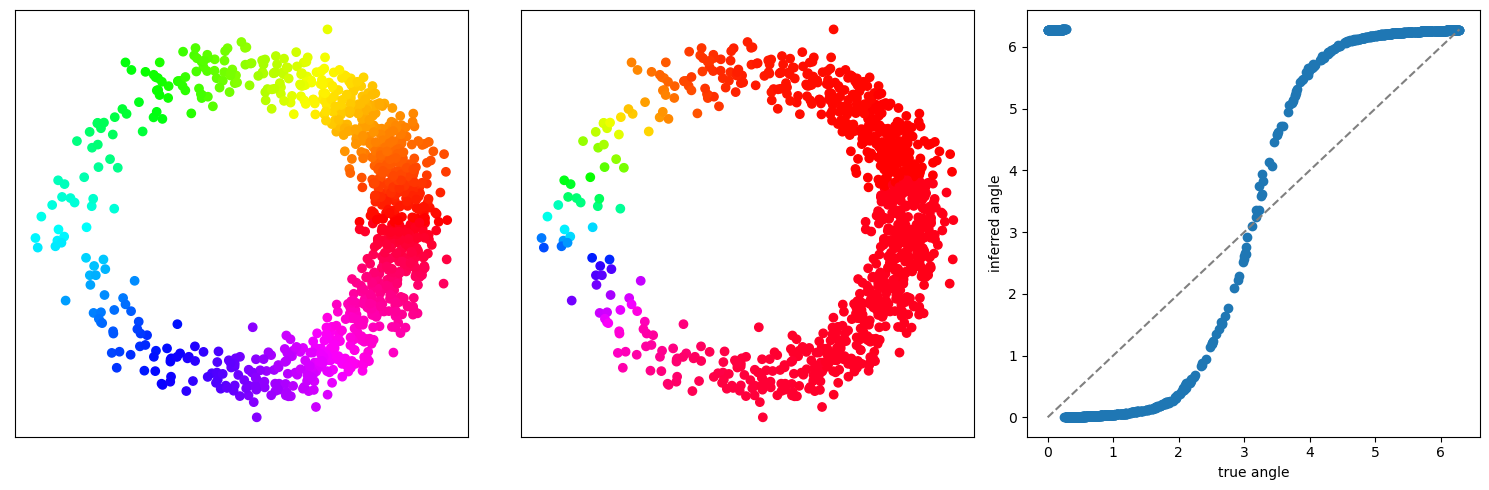

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

ax0.scatter(x, y, c=t, cmap='hsv')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.scatter(x, y, c=circle_orig_phase, cmap='hsv')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.scatter(2 * np.pi * t, 2 * np.pi * circle_orig_phase)
ax2.set_xlabel('true angle')
ax2.set_ylabel('inferred angle')
ax2.plot([0, 2 * np.pi], [0, 2 * np.pi], c='grey', ls='--')
plt.tight_layout()

# plt.savefig('images/circle_uncorrected.png', bbox_inches='tight')
plt.show()

In [14]:
sampled_phases, circle_corrected_phase = run(circle_xy, size=50)
circle_corrected_phase = op_align(circle_corrected_phase, t)

/var/folders/r9/13bx_vn958b3mvd7s7n9pzjr0000gp/T/ipykernel_1757/2564625988.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


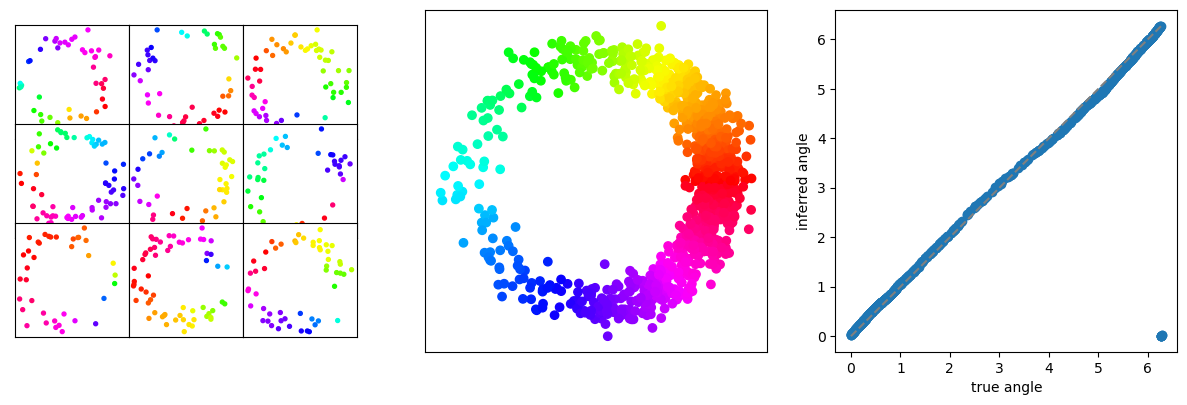

In [15]:
fig = plt.figure(figsize=(15, 5))
outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2)

inner = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[0], wspace=0, hspace=-0.47)

for j in range(9):
    ax = plt.Subplot(fig, inner[j])
    ax.scatter(*zip(*circle_xy), s=8, c=sampled_phases[j, :], cmap='hsv')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('square')
    fig.add_subplot(ax)

ax = plt.Subplot(fig, outer[1])
ax.scatter(*zip(*circle_xy), c=circle_corrected_phase, cmap='hsv')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('square')
fig.add_subplot(ax)

ax = plt.Subplot(fig, outer[2])
ax.scatter(2 * np.pi * t, 2 * np.pi * circle_corrected_phase)
ax.set_xlabel('true angle')
ax.set_ylabel('inferred angle')
ax.plot([0, 2 * np.pi], [0, 2 * np.pi], c='grey', ls='--')
ax.axis('square')
fig.add_subplot(ax)

plt.tight_layout()
# plt.savefig('images/circle_corrected.png', bbox_inches='tight')
plt.show()

# Figure 2

In [16]:
a, b = 1.6, 1
r = rng.normal(1, 0.1, size=1000)
t = rng.vonmises(0, 1.3, size=1000)
t = np.mod(t, 2 * np.pi) / (2 * np.pi)
x = a * r * np.cos(2 * np.pi * t)
y = b * r * np.sin(2 * np.pi * t)
ellipse_xy = np.stack([x,y]).T

In [17]:
orig_phcoord = PHCoord()
orig_phcoord.fit(ellipse_xy)
ellipse_orig_phase = np.mod(orig_phcoord.phase, 1)
ellipse_orig_phase = op_align(ellipse_orig_phase, t)

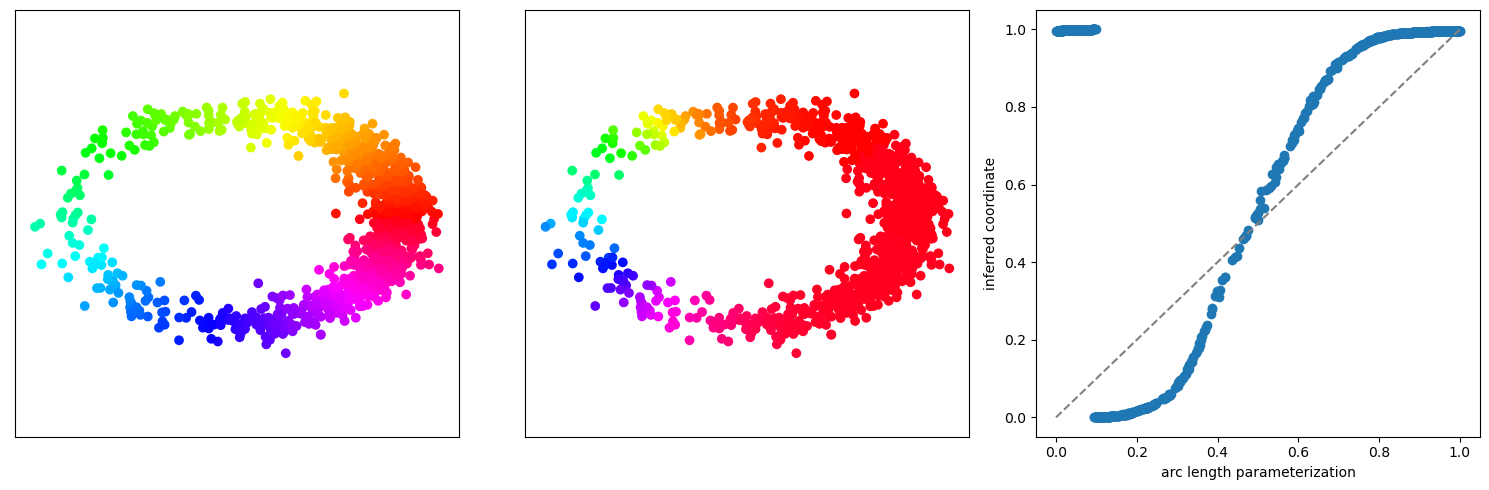

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

ax0.scatter(x, y, c=ellipeinc(t, 1 - (a / b) ** 2), cmap='hsv')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_aspect('equal', adjustable='datalim')

ax1.scatter(x, y, c=ellipse_orig_phase, cmap='hsv')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_aspect('equal', adjustable='datalim')

ax2.scatter(ellipeinc(2 * np.pi * t, 1 - (a / b) ** 2) / (4 * ellipe(1 - (a / b) ** 2)), ellipse_orig_phase)
ax2.set_xlabel('arc length parameterization')
ax2.set_ylabel('inferred coordinate')
ax2.plot([0, 1], [0, 1], c='grey', ls='--')

plt.tight_layout()

# plt.savefig('images/ellipse_uncorrected.png', bbox_inches='tight')
plt.show()

In [19]:
sampled_phases, ellipse_corrected_phase = run(ellipse_xy, size=50)
ellipse_corrected_phase = op_align(ellipse_corrected_phase, t)

/var/folders/r9/13bx_vn958b3mvd7s7n9pzjr0000gp/T/ipykernel_1757/738762518.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


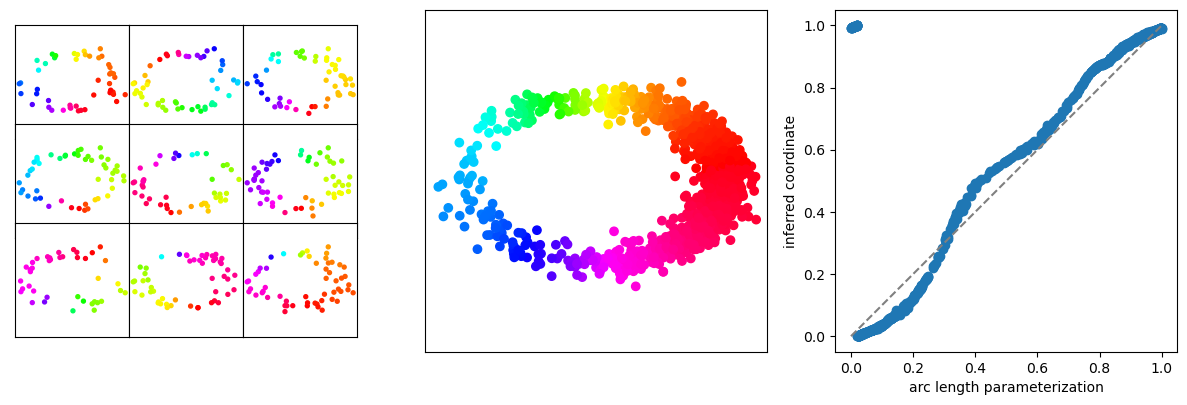

In [20]:
fig = plt.figure(figsize=(15, 5))
outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2)

inner = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[0], wspace=0, hspace=-0.47)

for j in range(9):
    ax = plt.Subplot(fig, inner[j])
    ax.scatter(*zip(*ellipse_xy), s=8, c=sampled_phases[j,:], cmap='hsv')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('square')
    ax.set_xlim(-2.1,2.1)
    ax.set_ylim(-2.1,2.1)
    fig.add_subplot(ax)

ax = plt.Subplot(fig, outer[1])
ax.scatter(x,y, c=ellipse_corrected_phase, cmap='hsv')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('square')
ax.set_xlim(-2.1,2.1)
ax.set_ylim(-2.1,2.1)
fig.add_subplot(ax)

ax = plt.Subplot(fig, outer[2])
ax.scatter(ellipeinc(2 * np.pi * t, 1 - (a / b) ** 2) / (4 * ellipe(1 - (a / b) ** 2)), ellipse_corrected_phase)
ax.set_xlabel('arc length parameterization')
ax.set_ylabel('inferred coordinate')
ax.plot([0, 1], [0, 1], c='grey', ls='--')
ax.axis('square')
fig.add_subplot(ax)

plt.tight_layout()
# plt.savefig('images/ellipse_corrected.png', bbox_inches='tight')
plt.show()

## Figure 3

In [11]:
kato_df = {i : pd.read_csv('../kato/df{}.csv'.format(i), header=[0,1], index_col=0) for i in range(1,6)}

In [12]:
kato_pca = dict()
kato_pca_res = dict()
for i, v in kato_df.items():
    df = v[['values', 'diffs']]
    #df_rolling = df.rolling(400, center=True, min_periods=1)
    #df_detrended = df # (df - df_rolling.mean()) #/ df_rolling.std()

    kato_pca[i] = PCA()
    kato_pca_res[i] = pd.DataFrame(kato_pca[i].fit_transform(df), index=df.index)

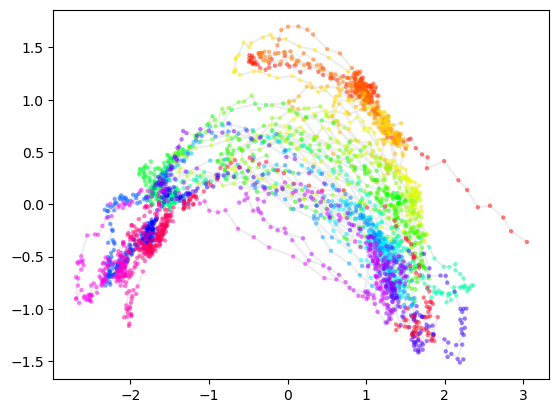

In [23]:
w = 3
plt.plot(kato_pca_res[w][0], kato_pca_res[w][1], c='lightgrey', alpha=0.4, zorder=0)
plt.scatter(kato_pca_res[w][0], kato_pca_res[w][1], c=kato_pca_res[w].index, cmap='hsv', s=10, alpha=0.5, ec=None)
plt.show()

In [13]:
n_dim = 5

In [25]:
%%time
ph_res= {w : ripser(v.iloc[:,:n_dim], coeff=47) for w, v in kato_pca_res.items()}

CPU times: user 3min, sys: 25.5 s, total: 3min 25s
Wall time: 3min 25s


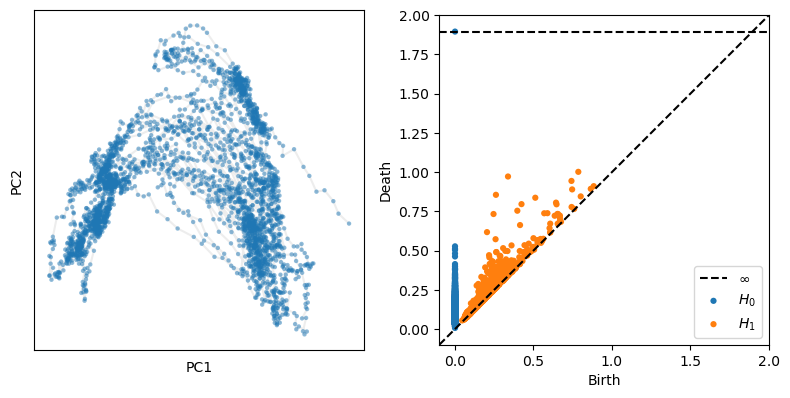

In [ ]:
w = 3

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))
ax0.plot(kato_pca_res[w][0], kato_pca_res[w][1], c='lightgrey', alpha=0.4, zorder=0)
ax0.scatter(kato_pca_res[w][0], kato_pca_res[w][1], cmap='hsv', s=10, alpha=0.5, ec=None)
ax0.set_xlabel('PC1')
ax0.set_xticks([])
ax0.set_ylabel('PC2')
ax0.set_yticks([])

plot_diagrams(ph_res[w]['dgms'], xy_range=[-0.1,2,-0.1,2], ax=ax1)

plt.tight_layout()
# plt.savefig('images/c-elegans_kato3_phdgm.png', bbox_inches='tight')
plt.show()

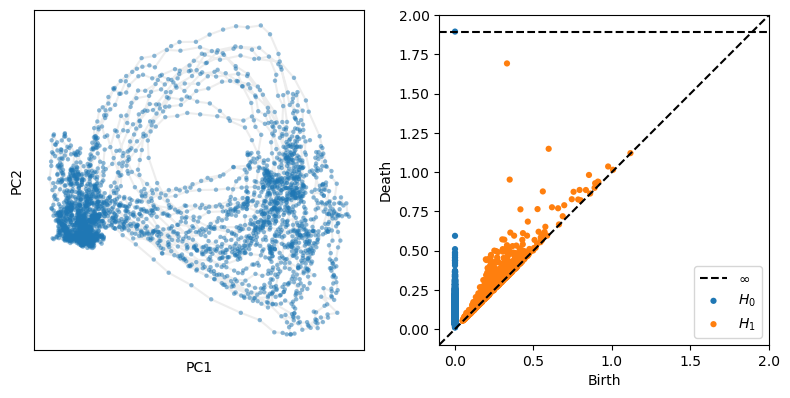

In [ ]:
w = 5

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))
ax0.plot(kato_pca_res[w][0], kato_pca_res[w][1], c='lightgrey', alpha=0.4, zorder=0)
ax0.scatter(kato_pca_res[w][0], kato_pca_res[w][1], cmap='hsv', s=10, alpha=0.5, ec=None)
ax0.set_xlabel('PC1')
ax0.set_xticks([])
ax0.set_ylabel('PC2')
ax0.set_yticks([])

plot_diagrams(ph_res[w]['dgms'], xy_range=[-0.1,2,-0.1,2], ax=ax1)

plt.tight_layout()
# plt.savefig('images/c-elegans_kato5_phdgm.png', bbox_inches='tight')
plt.show()

In [14]:
w = 5
ws = [w]

In [15]:
%%time
kato_naive_coords = dict()
for w in ws:
    phcoord = PHCoord()
    phcoord.fit(kato_pca_res[w].iloc[:,:n_dim])

    kato_naive_coords[w] = np.mod(phcoord.phase, 1)

    ref_coord = np.arctan2(kato_pca_res[w][0], kato_pca_res[w][1]).to_numpy()
    kato_naive_coords[w] = op_align(kato_naive_coords[w], ref_coord)

CPU times: user 19min 17s, sys: 8min 2s, total: 27min 20s
Wall time: 4min 3s


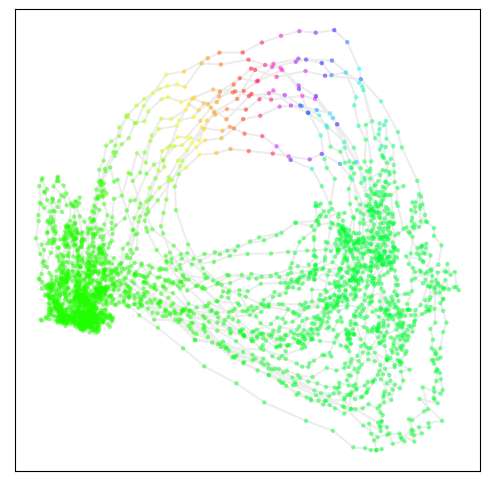

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(kato_pca_res[w][0], kato_pca_res[w][1], c='lightgrey', alpha=0.4, zorder=0)
plt.scatter(kato_pca_res[w][0], kato_pca_res[w][1], c=kato_naive_coords[w], cmap='hsv', vmin=0, vmax=1, s=10, alpha=0.5, ec=None)
plt.xticks([])
plt.yticks([])
# plt.savefig('images/c-elegans_kato5_pca_uncorrected.png', bbox_inches='tight')
plt.show()

In [16]:
%%time
kato_corrected_coords = dict()
for w in ws:
    _, kato_corrected_coords[w] = run(kato_pca_res[w].iloc[:,:n_dim], size=50)
    
    ref_coord = np.arctan2(kato_pca_res[w][0], kato_pca_res[w][1]).to_numpy()
    kato_corrected_coords[w] = op_align(kato_corrected_coords[w], ref_coord)

CPU times: user 20.3 s, sys: 2.21 s, total: 22.5 s
Wall time: 13 s


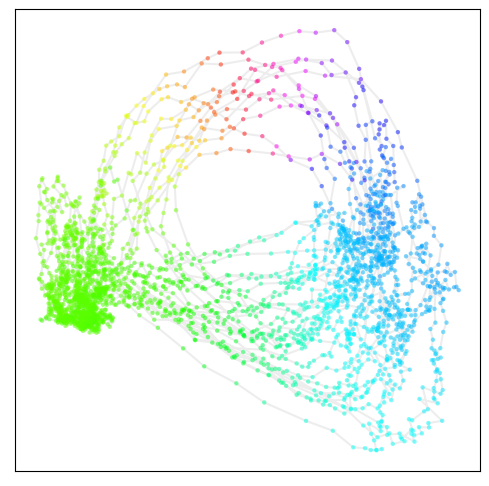

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(kato_pca_res[w][0], kato_pca_res[w][1], c='lightgrey', alpha=0.4, zorder=0)
plt.scatter(kato_pca_res[w][0], kato_pca_res[w][1], c=kato_corrected_coords[w], cmap='hsv', vmin=0, vmax=1, s=10, alpha=0.5, ec=None)
plt.xticks([])
plt.yticks([])
# plt.savefig('images/c-elegans_kato5_pca_corrected.png', bbox_inches='tight')
plt.show()

# Figure 4

In [33]:
raw_data = pd.read_csv('../kato/df5.csv', header=[0,1], index_col=0)

In [34]:
kato_coord = pd.DataFrame(index=kato_pca_res[w].index)
kato_coord['naive'] = kato_naive_coords[w]
kato_coord['count'] = kato_corrected_coords[w]

In [35]:
states_dict = {
    'FWD' : 'FWD',
    'SLOW' : 'FWD',
    'REV1' : 'REV',
    'REV2' : 'REV',
    'DT' : 'DT',
    'VT' : 'VT',
    'REVSUS' : 'REVSUS'
}

In [36]:
kato_coord['state'] = [states_dict.get(x) for x in raw_data['states']['states']]

In [37]:
color_key = {'FWD' : '#003FE7',
             'REV' : '#FF2A01',
             'REVSUS' : '#6AC25D',
             'DT' : '#FF8216',
             'VT' : '#FFD12B',
             None : 'grey'
            }

In [38]:
kato_coord['naive_diff'] = [np.mod(x + 0.5, 1) - 0.5 for x in kato_coord['naive'].diff()]
kato_coord['count_diff'] = [np.mod(x + 0.5, 1) - 0.5 for x in kato_coord['count'].diff()]

In [39]:
def sqrt_with_sign(x):
    return np.sign(x) * np.abs(x) ** (1/2)

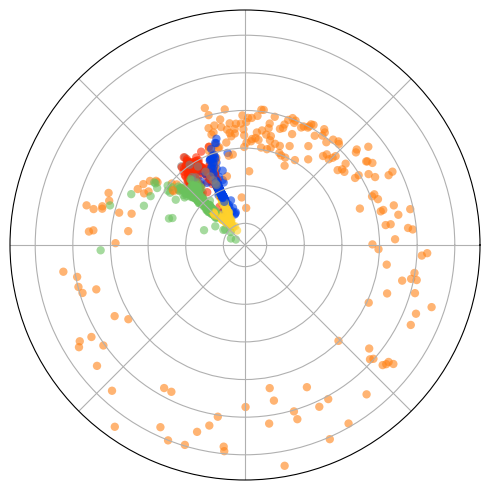

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), subplot_kw={'projection': 'polar'})
ax.scatter(
    2 * np.pi * kato_coord['naive'], 
    sqrt_with_sign(kato_coord['naive_diff']),
    c=[color_key[x] for x in kato_coord['state']], 
    alpha=0.6,
    ec=None
)
ax.set_xticklabels('')
ax.set_yticklabels('')
plt.tight_layout()
# plt.savefig('images/c-elegans_kato5_polar_uncorrected.png', bbox_inches='tight')
plt.show()

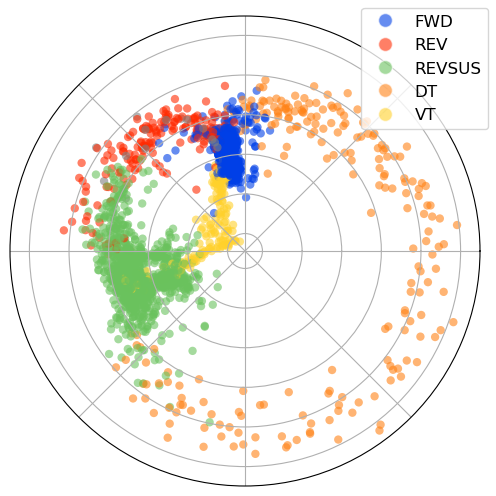

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), subplot_kw={'projection': 'polar'})
ax.scatter(
    2 * np.pi * kato_coord['count'], 
    sqrt_with_sign(kato_coord['count_diff']),
    c=[color_key[x] for x in kato_coord['state']], 
    alpha=0.6,
    ec=None
)
ax.set_xticklabels('')
ax.set_yticklabels('')
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, alpha=0.6, markersize=10) for k, v in color_key.items() if k is not None]
fig.legend(handles=legend_elements, prop={'size': 12})
plt.tight_layout()
# plt.savefig('images/c-elegans_kato5_polar_corrected.png', bbox_inches='tight')
plt.show()

## Figure 5

In [17]:
traces = pd.read_csv('../yemini/head_traces.csv', header=[0,1], index_col=0)
traces.columns.names = ['worm', 'neuron']
traces.columns = traces.columns.set_levels(traces.columns.levels[0].astype(int), level='worm')
traces.sort_index(axis=1, inplace=True)

worms = traces.columns.levels[0]

In [18]:
ws = [9, 10, 12, 17, 19, 20]
# ws = np.arange(1,22)

In [19]:
neurons = ['AVAL', 'AVAR', 'AVBL', 'AVBR']

In [20]:
df = {w : traces[w].reindex(neurons, axis=1).dropna(axis=1, how='all').dropna() for w in ws}

In [21]:
df_rolling = {k: v.rolling(240, center=True, min_periods=1) for (k,v) in df.items()}
df_detrended = {w: (df[w] - df_rolling[w].mean()) / df_rolling[w].std() for w in ws}

In [22]:
df_detrend_delay = {k: pd.concat([v, v.shift(-20), v.shift(-40), v.shift(-60), v.shift(-80)], axis=1, keys=[0,1,2,3,4]).dropna() for (k,v) in df_detrended.items()}

In [23]:
pca = {}
df_detrend_delay_pca = {}
for k, v in df_detrend_delay.items():
    pca[k] = PCA()
    df_detrend_delay_pca[k] = pca[k].fit_transform(v)

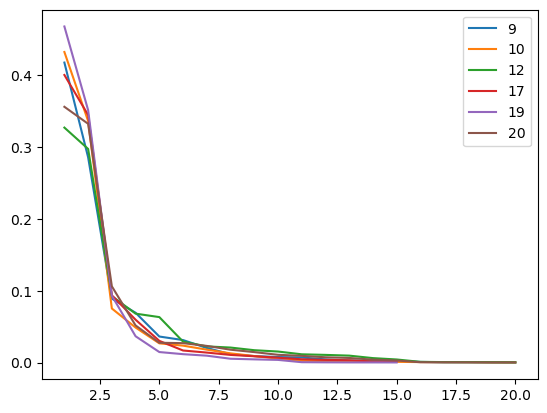

In [49]:
for w, p in pca.items():
    plt.plot(1 + np.arange(p.n_components_), p.explained_variance_ratio_, label=w)
plt.legend()
plt.show()

In [24]:
n_dim = 5

In [25]:
%%time
yemini_naive_coords = {}
for k, v in df_detrend_delay_pca.items():
    phcoord = PHCoord()
    phcoord.fit(v[:,:n_dim])
    yemini_naive_coords[k] = np.mod(phcoord.phase, 1)

    ref_coord = np.arctan2(v[:,0], v[:,1])
    yemini_naive_coords[k] = op_align(yemini_naive_coords[k], ref_coord)

CPU times: user 1min 38s, sys: 7.71 s, total: 1min 46s
Wall time: 41.2 s


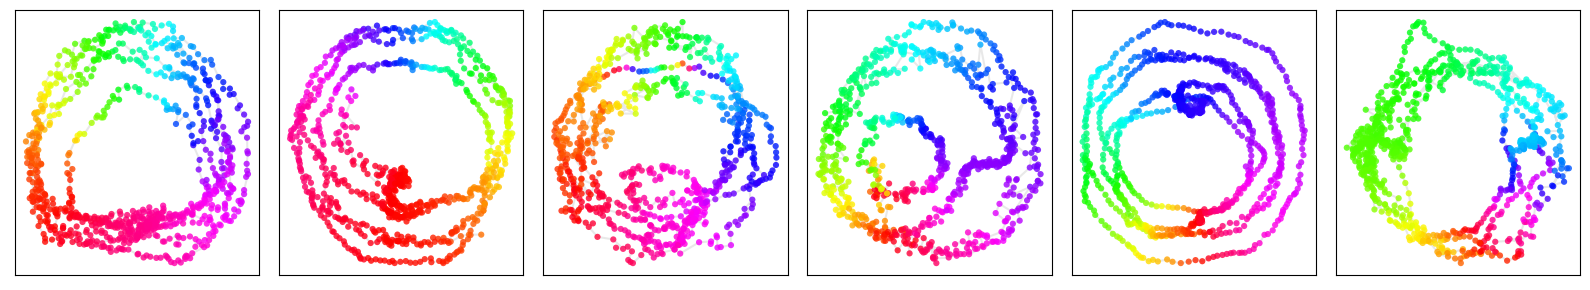

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(16,3))
for w, ax in zip(ws, fig.axes):
    ax.plot(df_detrend_delay_pca[w][:,0], df_detrend_delay_pca[w][:,1], c='lightgrey', alpha=0.5, zorder=0)
    ax.scatter(df_detrend_delay_pca[w][:,0], df_detrend_delay_pca[w][:,1], c=yemini_naive_coords[w], cmap='hsv', vmin=0, vmax=1, s=20, alpha=0.8, ec=None)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
# plt.savefig('images/c-elegans_yemini_pca_uncorrected.png', bbox_inches='tight')
plt.show()

In [26]:
%%time
yemini_corrected_coords = {}
for k, v in df_detrend_delay_pca.items():
    _, yemini_corrected_coords[k] = run(v[:,:n_dim], size=50)

    ref_coord = np.arctan2(v[:,0], v[:,1])
    yemini_corrected_coords[k] = op_align(yemini_corrected_coords[k], ref_coord)

CPU times: user 38.2 s, sys: 1.23 s, total: 39.4 s
Wall time: 15.6 s


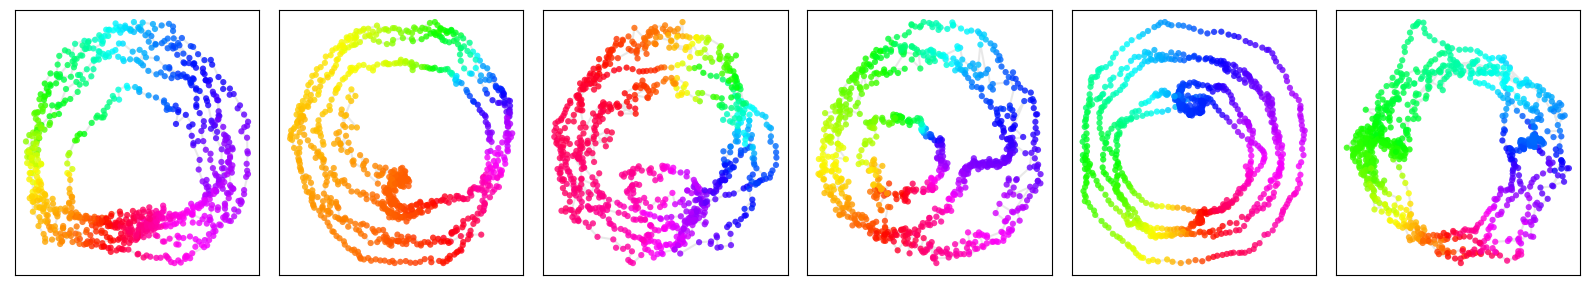

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(16,3))
for w, ax in zip(ws, fig.axes):
    ax.plot(df_detrend_delay_pca[w][:,0], df_detrend_delay_pca[w][:,1], c='lightgrey', alpha=0.5, zorder=0)
    ax.scatter(df_detrend_delay_pca[w][:,0], df_detrend_delay_pca[w][:,1], c=yemini_corrected_coords[w], cmap='hsv', vmin=0, vmax=1, s=20, alpha=0.8, ec=None)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
# plt.savefig('images/c-elegans_yemini_pca_corrected.png', bbox_inches='tight')
plt.show()
